1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
print(torchvision.__version__)

0.8.2+cu101


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
type(trainset.data)

numpy.ndarray

In [9]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
type(trainset.targets)

list

In [12]:
print('Original dataset shape %s' % collections.Counter(trainset.targets))


Original dataset shape Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [13]:
class unbalance_CIFAR10(CIFAR10):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_CIFAR10, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        

     
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 50,
                1: 5000,
                2: 50,
                3: 5000,
                4: 50,
                5: 5000,
                6: 50,
                7: 5000,
                8: 50,
                9: 5000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(50000,32*32*3), np.array(self.targets))
#         self.data, self.targets = torch.Tensor(self.data.reshape(-1,32,32,3)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)
        self.data, self.targets = self.data.reshape(-1,32,32,3), self.targets



In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 5000, 3: 5000, 5: 5000, 7: 5000, 9: 5000, 0: 50, 2: 50, 4: 50, 6: 50, 8: 50})


In [16]:
class_weights = compute_class_weight('balanced',np.unique(trainset.targets.tolist()),np.array(trainset.targets.tolist()))
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights = class_weights.to(device) 
print(class_weights)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[0 0 0 ... 9 9 9] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


tensor([50.5000,  0.5050, 50.5000,  0.5050, 50.5000,  0.5050, 50.5000,  0.5050,
        50.5000,  0.5050], device='cuda:0')


In [17]:
type(trainset.data)

numpy.ndarray

In [18]:
type(testset.data)

numpy.ndarray

In [19]:
trainset.data.shape

(25250, 32, 32, 3)

In [20]:
type(trainset.targets)

numpy.ndarray

In [21]:
len(trainset.data)

25250

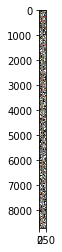

  car   car   dog horse


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight =class_weights,reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [25]:
import time
start = time.time()  # 시작 시간 저장

In [26]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 2.202
[2,    10] loss: 1.935
[3,    10] loss: 1.789
[4,    10] loss: 1.601
[5,    10] loss: 1.494
[6,    10] loss: 1.375
[7,    10] loss: 1.268
[8,    10] loss: 1.172
[9,    10] loss: 0.988
[10,    10] loss: 0.893
[11,    10] loss: 0.790
[12,    10] loss: 0.727
[13,    10] loss: 0.658
[14,    10] loss: 0.617
[15,    10] loss: 0.595
[16,    10] loss: 0.594
[17,    10] loss: 0.562
[18,    10] loss: 0.503
[19,    10] loss: 0.466
[20,    10] loss: 0.437
[21,    10] loss: 0.417
[22,    10] loss: 0.432
[23,    10] loss: 0.417
[24,    10] loss: 0.376
[25,    10] loss: 0.365
[26,    10] loss: 0.330
[27,    10] loss: 0.335
[28,    10] loss: 0.322
[29,    10] loss: 0.314
[30,    10] loss: 0.323
[31,    10] loss: 0.298
[32,    10] loss: 0.286
[33,    10] loss: 0.276
[34,    10] loss: 0.263
[35,    10] loss: 0.259
[36,    10] loss: 0.242
[37,    10] loss: 0.241
[38,    10] loss: 0.239
[39,    10] loss: 0.230
[40,    10] loss: 0.217
[41,    10] loss: 0.208
[42,    10] loss: 0.207
[

In [27]:
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 391.54066348075867


In [28]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:   frog  frog  bird   car plane truck  ship   car  bird  deer  ship  bird  deer  frog plane plane horse  deer  deer  frog plane truck horse  bird  ship horse plane  deer  bird  ship  bird   cat horse  bird plane  frog  bird plane horse plane   cat   cat plane  frog   dog  deer  ship  deer plane plane  deer  bird truck horse truck   cat  bird truck  bird  ship  frog truck plane   car


In [30]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [31]:
net.train()
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:    car horse   dog   car plane truck   cat   car truck   dog   car plane horse   cat  ship   cat horse  deer   cat   dog  frog truck horse   car truck horse   dog horse   dog  ship   cat   cat horse   dog   car   cat   dog   cat horse horse   dog   dog horse   cat   dog horse   cat   cat horse truck horse   dog truck horse   car   dog   cat truck   cat   car   cat truck   car   car  bird   cat horse plane   dog   car horse   dog truck  deer truck   dog   dog horse   car truck horse truck   dog   cat   cat  ship   dog horse horse   dog horse   car horse   car   car horse   car   cat truck   cat truck   dog   dog   car horse   dog horse   car   car   dog   car   dog horse truck   cat  bird   dog   car   car horse   cat   dog horse truck truck   dog   dog   dog horse   cat plane truck truck   car horse horse   car   car   cat horse horse truck   dog   dog   dog   dog   dog plane   dog   cat  ship   car horse truck   dog   dog   dog   dog truck   cat horse horse   car horse   do

In [33]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [34]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 19.8 %
Accuracy for class car   is: 91.2 %
Accuracy for class bird  is: 4.1 %
Accuracy for class cat   is: 64.3 %
Accuracy for class deer  is: 3.4 %
Accuracy for class dog   is: 76.0 %
Accuracy for class frog  is: 14.5 %
Accuracy for class horse is: 86.0 %
Accuracy for class ship  is: 16.5 %
Accuracy for class truck is: 88.8 %


In [35]:
for i in range(10):
    print(classes[labels[i]])

dog
truck
plane
truck
cat
plane
ship
horse
car
truck
